## Prompt Metadata

#### Metadata File to pandas dataframe

In [1]:
from src.utils import read_yaml
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from src.factories import dataLoaderFactory, teacherResponseParserFactory
from src.teacher_response_evaluator import TeacherResponseEvaluator

c:\Projects\master-thesis\ZeroShot-step-by-step-distillation\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def get_meta_df(dataset: str) -> pd.DataFrame:
    metadata = read_yaml(f"prompt-metadata/{dataset}.yaml")

    # flatten metadata and convert to dataframe
    metadata = {k: {**v['costs'], **v['characteristics'], **v['performance']} for k, v in metadata.items()}
    meta_df = pd.DataFrame.from_dict(metadata, orient='index')

    # Add PALM FewShot Performance to meta_df
    # Load PALM predictions and rationales
    
    dataset_loader = dataLoaderFactory(dataset)
    train_llm_rationales, train_llm_labels = dataset_loader.load_llm_preds(split="train")

    parsed_responses = {i: (label, rational) for i, (label, rational) in enumerate(zip(train_llm_labels, train_llm_rationales))}

    evaluator = TeacherResponseEvaluator(dataset)

    label_eval = evaluator.get_label_accuracy(split="train", parsed_responses=parsed_responses)
    rationale_eval = evaluator.get_explanation_characteristics(parsed_responses=parsed_responses)

    palm_eval = {"accuracy": label_eval[0],
             "n_correct": label_eval[1],
             "n_wrong": label_eval[2],
             "n_none_responses": rationale_eval[0],
             "total_responses": rationale_eval[1],
             "total_length_of_explanations": rationale_eval[2],
             "total_number_of_sentences": rationale_eval[3],
             "total_number_of_words": rationale_eval[4],
             "flesch_reading_ease": rationale_eval[5],
             "variance_length_of_explanations": rationale_eval[6],
             "avg_len_of_explanations": rationale_eval[2] / rationale_eval[1],
             "avg_nr_of_sentences": rationale_eval[3] / rationale_eval[1],
             "avg_nr_of_words": rationale_eval[4] / rationale_eval[1],
             "n_parse_errors": 0,
             }
    
    # insert PALM evaluation into metadata dataframe with index 0
    meta_df = pd.concat([pd.DataFrame(palm_eval, index=[0]), meta_df])

    # add column with explanation rate = total responses / (n_correct + n_wrong)
    meta_df["explanation_rate"] = meta_df["total_responses"] / (meta_df["n_correct"] + meta_df["n_wrong"])

    return meta_df

In [3]:
## Check GPT35 performance on validation set
#test_gpt35_rationales, test_gpt35_labels = dataset_loader.load_gpt35_preds(split="valid", prompt_mix_id=6)
#parsed_responses_gpt35 = {i: (label, rational) for i, (label, rational) in enumerate(zip(test_gpt35_labels, test_gpt35_rationales))}
#evaluator.get_label_accuracy(split="valid", parsed_responses=parsed_responses_gpt35)

In [3]:
meta_df = get_meta_df("anli1")
meta_df.head()

,accuracy,n_correct,n_wrong,n_none_responses,total_responses,total_length_of_explanations,total_number_of_sentences,total_number_of_words,flesch_reading_ease,variance_length_of_explanations,...,avg_nr_of_words,n_parse_errors,avg_cost_per_query,avg_nr_tokens_received,avg_nr_tokens_sent,total_accumulated_costs,total_performed_queries,total_tokens_received,total_tokens_sent,explanation_rate
0,0.709076,12016,4930,0,16946,1925445,25264,326230,63.22534,2689.366852,...,19.251151,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.00
1,0.592000,74,51,0,125,15470,130,2583,47.30000,1687.254000,...,20.660000,0,0.00020,30.08,125.28,0.025320,125.0,3760.0,15660.0,1.00
2,0.456000,57,68,0,125,21123,137,3396,40.80000,2083.536000,...,27.170000,0,0.00033,40.82,215.10,0.041242,125.0,5103.0,26887.0,1.00
3,0.576000,72,53,125,0,0,0,0,0.00000,NaN,...,0.000000,0,0.00015,2.78,123.28,0.019296,125.0,347.0,15410.0,0.00
4,0.600000,30,20,2,48,15915,140,2580,46.50000,27909.496000,...,53.750000,1,0.00037,89.04,126.84,0.018417,50.0,4452.0,6342.0,0.96


In [4]:
# sort meta_df by accuracy
meta_df.sort_values(by=["accuracy"], ascending=False).head(10)

,accuracy,n_correct,n_wrong,n_none_responses,total_responses,total_length_of_explanations,total_number_of_sentences,total_number_of_words,flesch_reading_ease,variance_length_of_explanations,...,avg_nr_of_words,n_parse_errors,avg_cost_per_query,avg_nr_tokens_received,avg_nr_tokens_sent,total_accumulated_costs,total_performed_queries,total_tokens_received,total_tokens_sent,explanation_rate
179,1.000000,110,0,0,110,14326,111,2402,48.20000,1405.235000,...,21.840000,0,0.00030,39.89,145.82,5.356910,17946.0,715838.0,2616823.0,1.000000
100,0.709800,12028,4918,2173,14773,3069997,24926,500537,43.10000,14076.337000,...,33.880000,45,0.00030,60.61,119.99,5.650959,18761.0,1137078.0,2251202.0,0.871769
0,0.709076,12016,4930,0,16946,1925445,25264,326230,63.22534,2689.366852,...,19.251151,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000
32,0.678300,78,37,20,95,16724,151,2739,51.00000,9259.830000,...,28.830000,0,0.00032,64.24,130.17,0.037231,115.0,7388.0,14970.0,0.826087
28,0.660000,33,17,17,33,5441,42,878,40.40000,4813.622000,...,26.610000,0,0.00027,31.92,134.80,0.013302,50.0,1596.0,6740.0,0.660000
149,0.660000,33,17,34,16,2825,22,461,47.00000,15896.996000,...,28.810000,0,0.00026,24.02,139.76,0.012884,50.0,1201.0,6988.0,0.320000
123,0.640000,32,18,21,29,4177,38,689,47.40000,6155.275000,...,23.760000,0,0.00029,37.74,141.12,0.014358,50.0,1887.0,7056.0,0.580000
122,0.640000,32,18,39,11,1738,14,266,35.00000,5070.364000,...,24.180000,0,0.00026,12.48,156.16,0.012960,50.0,624.0,7808.0,0.220000
58,0.640000,32,18,12,38,6087,51,995,46.80000,6441.098000,...,26.180000,0,0.00030,47.10,135.12,0.014844,50.0,2355.0,6756.0,0.760000
134,0.640000,32,18,18,32,4467,49,729,52.40000,7051.679000,...,22.780000,0,0.00031,52.00,140.14,0.015710,50.0,2600.0,7007.0,0.640000


## Plots

Text(0.5, 1.0, 'Variance of Length of Explanations')

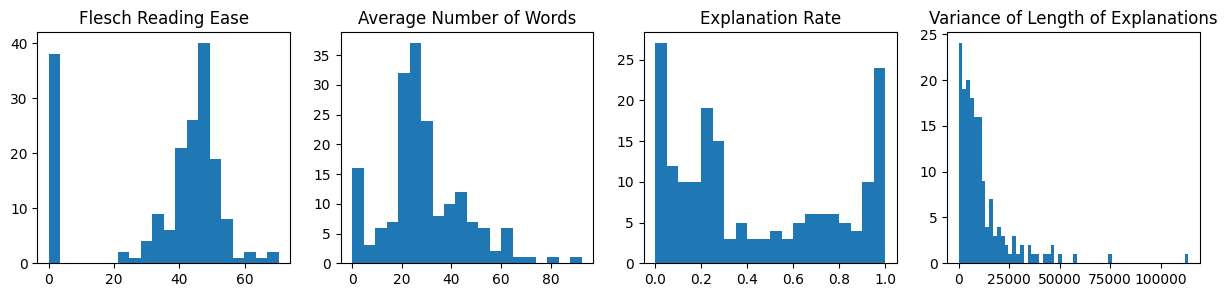

In [5]:
# histograms of: flesh reading ease, avg_nr_of_sentences, avg_nr_of_words, variance_length_of_explanations
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(15, 3))
ax1.hist(meta_df["flesch_reading_ease"], bins=20)
ax1.set_title("Flesch Reading Ease")
ax2.hist(meta_df["avg_nr_of_words"], bins=20)
ax2.set_title("Average Number of Words")
ax3.hist(meta_df["explanation_rate"], bins=20)
ax3.set_title("Explanation Rate")
ax4.hist(meta_df["variance_length_of_explanations"], bins=60)
ax4.set_title("Variance of Length of Explanations")

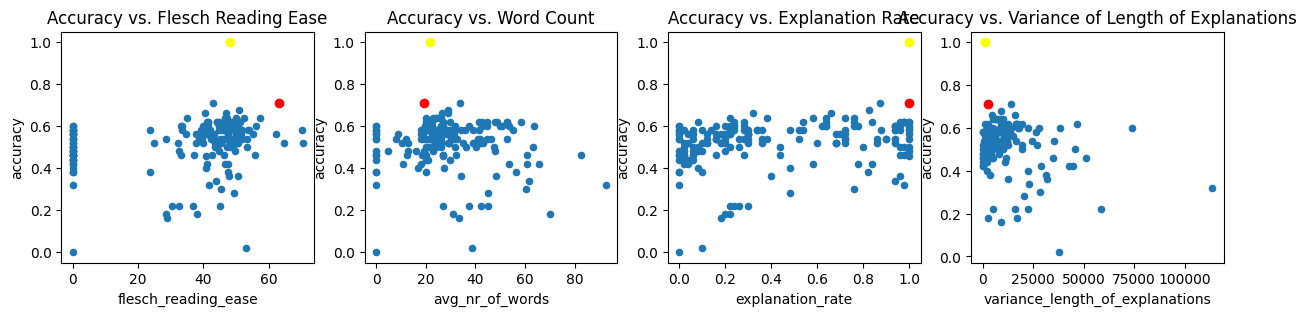

In [6]:
# scatter plots of accuracy vs. flesch reading ease alongside accuracy vs. word count, alongside acc vs. n_responses, alongside acc vs. variance of length of explanations
# collor point with index 0 red to indicate PALM
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(15, 3))
meta_df.plot.scatter(x="flesch_reading_ease", y="accuracy", title="Accuracy vs. Flesch Reading Ease", ax=ax1)
meta_df.plot.scatter(x="avg_nr_of_words", y="accuracy", title="Accuracy vs. Word Count", ax=ax2)
meta_df.plot.scatter(x="explanation_rate", y="accuracy", title="Accuracy vs. Explanation Rate", ax=ax3)
meta_df.plot.scatter(x="variance_length_of_explanations", y="accuracy", title="Accuracy vs. Variance of Length of Explanations", ax=ax4)

HIGHLIGHT = 179
ax1.scatter(meta_df.iloc[0]['flesch_reading_ease'], meta_df.iloc[0]['accuracy'], color='red')
ax1.scatter(meta_df.iloc[HIGHLIGHT]['flesch_reading_ease'], meta_df.iloc[HIGHLIGHT]['accuracy'], color='yellow')
ax2.scatter(meta_df.iloc[0]['avg_nr_of_words'], meta_df.iloc[0]['accuracy'], color='red')
ax2.scatter(meta_df.iloc[HIGHLIGHT]['avg_nr_of_words'], meta_df.iloc[HIGHLIGHT]['accuracy'], color='yellow')
ax3.scatter(meta_df.iloc[0]['explanation_rate'], meta_df.iloc[0]['accuracy'], color='red')
ax3.scatter(meta_df.iloc[HIGHLIGHT]['explanation_rate'], meta_df.iloc[HIGHLIGHT]['accuracy'], color='yellow')
ax4.scatter(meta_df.iloc[0]['variance_length_of_explanations'], meta_df.iloc[0]['accuracy'], color='red')
ax4.scatter(meta_df.iloc[HIGHLIGHT]['variance_length_of_explanations'], meta_df.iloc[HIGHLIGHT]['accuracy'], color='yellow')

Good prompts, that deliver the most accurate results, seem to produce short (between 20 and 30 words), high FRE (above 45) explanations.

There seem to be the following tendencies:
 - The lower the FRE, the lower the accuracy. So complicated explanations are not good for the prediction.
 - The longer the explanation, the lower the accuracy. So long explanations are not good for the prediction.
 - However, very short explanations (< 20 words) are also not good for the prediction.
 - Wether a prompt makes the model return an explanation at all, does not seem to have an influence on the accuracy.

<Axes: title={'center': 'Parse Errors vs. Explanation Rate'}, xlabel='explanation_rate', ylabel='n_parse_errors'>

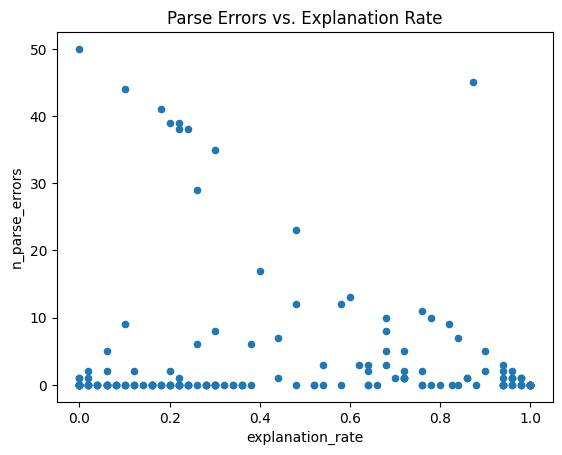

In [7]:
meta_df.plot.scatter(x="explanation_rate", y="n_parse_errors", title="Parse Errors vs. Explanation Rate")

<Axes: title={'center': 'Accuracy vs. Index'}>

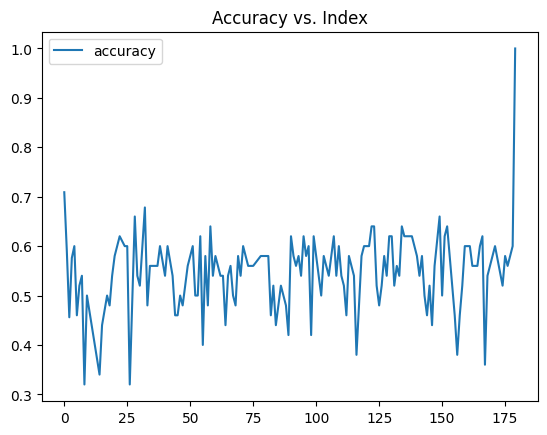

In [8]:
# line plot of accuracy vs index, filtered by n_parse_errors < 10
meta_df[meta_df["n_parse_errors"] < 5].plot.line(y="accuracy", title="Accuracy vs. Index")

<Axes: title={'center': 'Max Accuracy vs. Index'}>

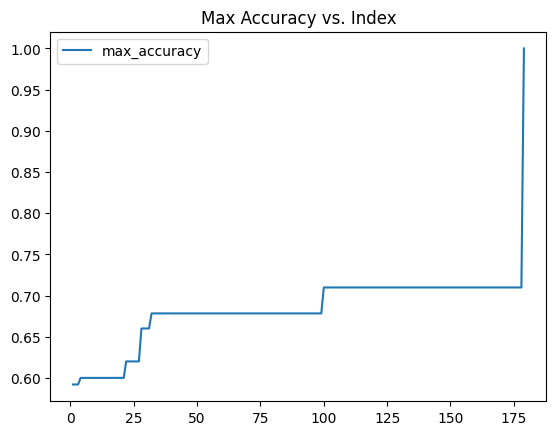

In [9]:
# line plot showing max accuracy so far vs. index, starting from index 1
meta_df["max_accuracy"] = meta_df.drop(0, axis=0)["accuracy"].cummax()
meta_df.plot.line(y="max_accuracy", title="Max Accuracy vs. Index")

In [17]:
meta_df[(meta_df["flesch_reading_ease"] < 30) & (meta_df["flesch_reading_ease"] > 10)].sort_values(by=["accuracy"], ascending=False).head(10)

,accuracy,n_correct,n_wrong,n_none_responses,total_responses,total_length_of_explanations,total_number_of_sentences,total_number_of_words,flesch_reading_ease,variance_length_of_explanations,...,n_parse_errors,avg_cost_per_query,avg_nr_tokens_received,avg_nr_tokens_sent,total_accumulated_costs,total_performed_queries,total_tokens_received,total_tokens_sent,explanation_rate,max_accuracy
78,0.58,29,21,45,5,691,5,105,23.8,1022.960,...,0,0.00022,7.96,136.76,0.011053,50.0,398.0,6838.0,0.10,0.6783
40,0.54,27,23,42,8,982,8,146,28.6,1704.688,...,0,0.00022,6.20,137.76,0.010952,50.0,310.0,6888.0,0.16,0.6783
83,0.52,26,24,45,5,805,6,122,24.8,3032.000,...,0,0.00024,5.44,152.76,0.012001,50.0,272.0,7638.0,0.10,0.6783
87,0.38,19,31,45,5,662,5,100,23.6,3648.240,...,9,0.00025,10.40,152.14,0.012450,50.0,520.0,7607.0,0.10,0.6783
173,0.18,9,41,40,10,4556,31,702,28.6,16902.640,...,39,0.00038,93.68,125.14,0.018753,50.0,4684.0,6257.0,0.20,0.7098
77,0.16,8,42,41,9,1917,13,301,28.8,8971.556,...,41,0.00031,62.16,121.14,0.015302,50.0,3108.0,6057.0,0.18,0.6783


<Axes: title={'center': 'Parse Errors vs. Explanation Rate'}, xlabel='avg_nr_of_words', ylabel='flesch_reading_ease'>

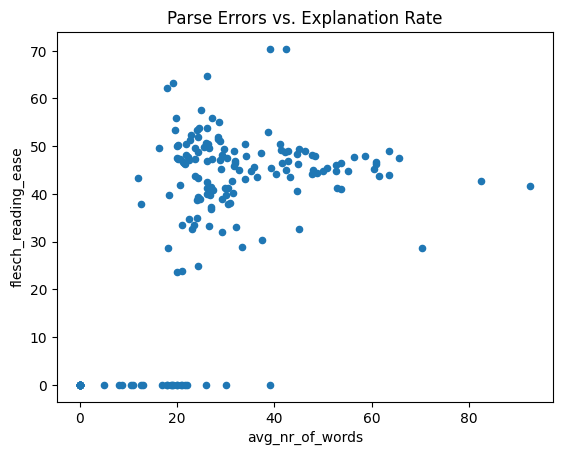

In [22]:
meta_df.plot.scatter(x="avg_nr_of_words", y="flesch_reading_ease", title="Parse Errors vs. Explanation Rate")

## Training Results

In [18]:
experiments = pd.read_csv('experiment-tracking/experiment_tracking.csv')
experiments.head()

,experiment_group,category,dataset,model,mode,llm,subsample,prompt_mix,label_type,alpha,max_input_length,batch_size,optimizer,lr,run,train_duration,train_steps,test_acc,eval_acc
0,Subsampling ANLI1,standard Finetuning,anli1,t5-v1_1-base,standard,NaN,0.125,0,gt,0.5,1024,64,AdamW,0.00005,0,2528.0,3750.0,0.349,0.347
1,Subsampling ANLI1,standard Finetuning,anli1,t5-v1_1-base,standard,NaN,0.250,0,gt,0.5,1024,64,AdamW,0.00005,0,3738.0,5500.0,0.434,0.403
2,Subsampling ANLI1,standard Finetuning,anli1,t5-v1_1-base,standard,NaN,0.500,0,gt,0.5,1024,64,AdamW,0.00005,0,8497.0,9500.0,0.346,0.342
3,Subsampling ANLI1,standard Finetuning,anli1,t5-v1_1-base,standard,NaN,1.000,0,gt,0.5,1024,64,AdamW,0.00005,0,5848.0,6500.0,0.341,0.334
4,RERUN Subsampling ANLI1,standard Finetuning,anli1,t5-v1_1-base,standard,NaN,0.500,0,gt,0.5,1024,32,AdamW,0.00005,1,2896.0,10000.0,0.432,0.391


In [19]:
finetuning_subsample = experiments.query("label_type == 'gt'")

In [20]:
filtered_df = finetuning_subsample.query("dataset == 'anli1' and  prompt_mix in [0, 6, 7] and model == 't5-v1_1-base'")

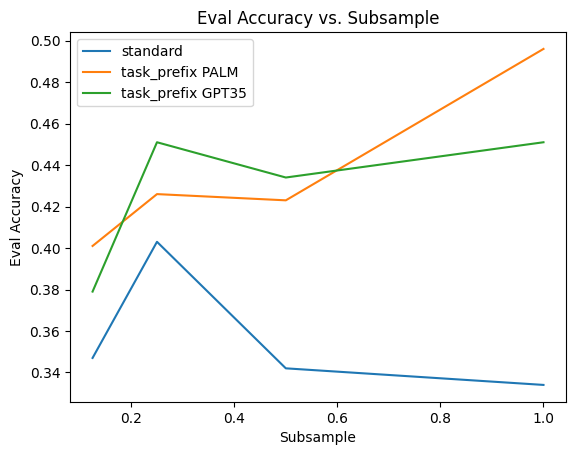

In [21]:
## line plot of eval_acc vs. subsample with two lines, one for mode == standard and one for mode == task_prefix
fig, ax = plt.subplots()
filtered_df = filtered_df.query("run == 0")
filtered_df[filtered_df["mode"] == "standard"].plot.line(x="subsample", y="eval_acc", ax=ax, label="standard")
filtered_df[(filtered_df["mode"] == "task_prefix") & (filtered_df["llm"] == "palm")].plot.line(x="subsample", y="eval_acc", ax=ax, label="task_prefix PALM")
filtered_df[(filtered_df["mode"] == "task_prefix") & (filtered_df["llm"] == "gpt35")].plot.line(x="subsample", y="eval_acc", ax=ax, label="task_prefix GPT35")
ax.set_title("Eval Accuracy vs. Subsample")
ax.set_ylabel("Eval Accuracy")
ax.set_xlabel("Subsample")
ax.legend()

In [40]:
experiments.groupby(["mode", "batch_size", "label_type", "llm"])["train_duration"].mean()

mode         batch_size  label_type  llm  
standard     32          llm         gpt35    2486.714286
                                     palm     2862.000000
             64          llm         gpt35    5957.000000
                                     palm     5296.000000
task_prefix  32          gt          gpt35    3614.750000
                         llm         gpt35    5615.777778
             64          gt          gpt35            NaN
                                     palm     8711.000000
                         llm         gpt35            NaN
                                     palm     8625.888889
Name: train_duration, dtype: float64